# Librerias

In [2]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
import pmdarima as pm
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from statsmodels.stats.diagnostic import acorr_ljungbox

In [3]:
# === Helpers seguros (RMSE sin squared=False y fecha asof) ===
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def rmse_safe(y_true, y_pred):
    # sqrt(MSE) para evitar el parámetro squared=False
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mape_safe(y_true, y_pred):
    df_eval = pd.DataFrame({"y": y_true, "yhat": y_pred}).dropna()
    if df_eval.empty:
        return np.nan
    denom = df_eval["y"].replace(0, np.nan)
    return float((np.abs((df_eval["y"] - df_eval["yhat"]) / denom)).mean() * 100)

def last_train_asof(series_index, cutoff_date_str):
    # Reemplazo para get_loc(method="pad"): última fecha <= cutoff
    return series_index.asof(pd.Timestamp(cutoff_date_str))


# Token

In [4]:
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["axes.grid"] = True

BANXICO_TOKEN = "caa9ce3af73a7040c54f64908e2af98fd965b7c816828c6d90836ff2dd38a9d2"

# === 3. Definir serie y rango de fechas ===
serie_id = "SF43783"   # TIIE 28 días
fecha_ini = "2000-01-01"   # desde el año 2000
fecha_fin = pd.Timestamp.today().strftime("%Y-%m-%d")

# === 4. Descargar datos desde la API ===
url = f"https://www.banxico.org.mx/SieAPIRest/service/v1/series/{serie_id}/datos/{fecha_ini}/{fecha_fin}"
headers = {"Bmx-Token": BANXICO_TOKEN}
response = requests.get(url, headers=headers)

if response.status_code != 200:
    raise ValueError(f"Error en la API: {response.status_code}, {response.text}")

data = response.json()
datos = data["bmx"]["series"][0]["datos"]

# === 5. Crear DataFrame ===
df = pd.DataFrame(datos)
df["fecha"] = pd.to_datetime(df["fecha"], format="%d/%m/%Y", dayfirst=True)
df["dato"] = pd.to_numeric(df["dato"].replace({"N/E": pd.NA}), errors="coerce")

# Indexamos por fecha y ordenamos
df = df.set_index("fecha").sort_index()

# === 6. Verificación ===
print(df.info())
print(df.head())
print(df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6473 entries, 2000-01-03 to 2025-09-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   dato    6473 non-null   float64
dtypes: float64(1)
memory usage: 101.1 KB
None
              dato
fecha             
2000-01-03  18.760
2000-01-04  18.560
2000-01-05  18.615
2000-01-06  18.655
2000-01-07  18.675
              dato
fecha             
2025-09-11  8.0126
2025-09-12  8.0126
2025-09-15  8.0126
2025-09-17  8.0226
2025-09-18  8.0226


In [5]:
# Conteo total de nulos en la columna
print("Total de valores nulos:", df["dato"].isna().sum())

# Conteo de nulos por año (para ver en qué periodos están concentrados)
print("\nValores nulos por año:")
print(df["dato"].isna().groupby(df.index.year).sum())

Total de valores nulos: 0

Valores nulos por año:
fecha
2000    0
2001    0
2002    0
2003    0
2004    0
2005    0
2006    0
2007    0
2008    0
2009    0
2010    0
2011    0
2012    0
2013    0
2014    0
2015    0
2016    0
2017    0
2018    0
2019    0
2020    0
2021    0
2022    0
2023    0
2024    0
2025    0
Name: dato, dtype: int64


In [6]:
df

,dato
fecha,
2000-01-03,18.7600
2000-01-04,18.5600
2000-01-05,18.6150
2000-01-06,18.6550
2000-01-07,18.6750
...,...
2025-09-11,8.0126
2025-09-12,8.0126
2025-09-15,8.0126


### No hay datos nulos ni fines de semana inventados

## reporte simple de rango temporal y valores máximos/mínimos

Fecha inicial: 2000-01-03 00:00:00
Fecha final: 2025-09-18 00:00:00
Número total de observaciones: 6473

Resumen estadístico:
count    6473.000000
mean        7.447035
std         3.246357
min         3.274100
25%         4.840000
50%         7.373000
75%         8.720000
max        19.450000
Name: dato, dtype: float64

Valor máximo: 19.45 el 2000-02-02
Valor mínimo: 3.27 el 2014-09-29


<Axes: title={'center': 'TIIE 28 días - Serie completa'}, xlabel='fecha'>

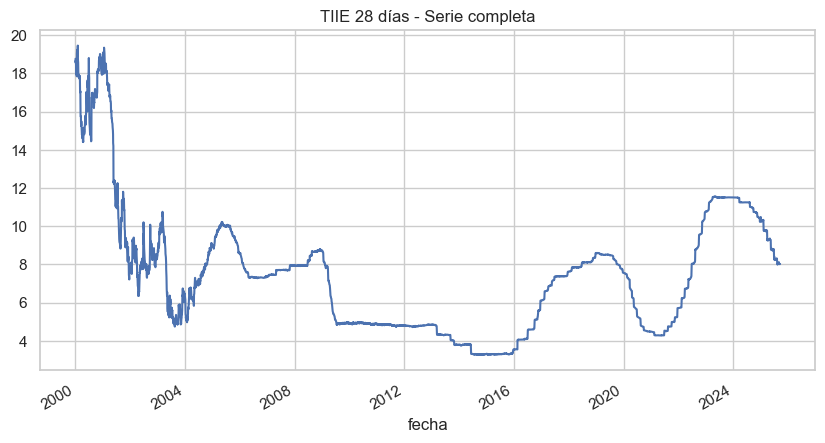

In [7]:
# === Rango temporal ===
print("Fecha inicial:", df.index.min())
print("Fecha final:", df.index.max())
print("Número total de observaciones:", len(df))

# === Valores extremos ===
print("\nResumen estadístico:")
print(df["dato"].describe())

# === Valores máximos y mínimos concretos ===
max_date = df["dato"].idxmax()
min_date = df["dato"].idxmin()
print(f"\nValor máximo: {df['dato'].max():.2f} el {max_date.date()}")
print(f"Valor mínimo: {df['dato'].min():.2f} el {min_date.date()}")

# === Gráfica rápida de toda la serie ===
df["dato"].plot(title="TIIE 28 días - Serie completa")


### Los valores de los primeros años (2000–2003) son bastante más altos (≈ 15–19%) que el resto de la historia reciente.

### A partir de 2010 en adelante, la TIIE se mueve en un rango más estable (≈ 3–12%), que es lo más relevante para el presente.

### Recorta la serie del 2010 en adelante para:

### Evitar los valores extremos de los primeros años que pueden sesgar la varianza y dificultar la estacionariedad.

### Además esos datos viejos probablemente no sean tan representativos de la política monetaria reciente.

Nuevo rango temporal:
Fecha inicial: 2010-01-04 00:00:00
Fecha final: 2025-09-18 00:00:00
Número de observaciones: 3953


<Axes: title={'center': 'TIIE 28 días desde 2010'}, xlabel='fecha'>

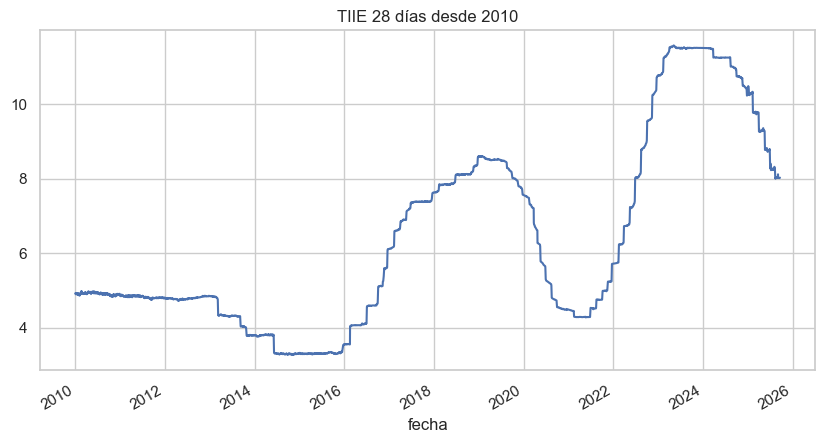

In [8]:
# Filtrar desde 2010
df_recorte = df.loc["2010-01-01":].copy()

print("Nuevo rango temporal:")
print("Fecha inicial:", df_recorte.index.min())
print("Fecha final:", df_recorte.index.max())
print("Número de observaciones:", len(df_recorte))

# Gráfica
df_recorte["dato"].plot(title="TIIE 28 días desde 2010")


### Entre 2010–2016 la TIIE estuvo en un rango bajo (≈ 3–5%).

### De 2016 a 2019 hubo una subida fuerte hasta ≈ 8.5%.

### Luego bajó con la pandemia (2020–2021).

### A partir de 2022 volvió a subir hasta ≈ 11.5% y ahora está en descenso en 2025.

### Esto es consistente con la política monetaria reciente de Banxico.

# EDA

In [9]:
# 1. Estadísticos básicos

print("Resumen estadístico:\n", df_recorte["dato"].describe())
print("\nValor máximo:", df_recorte["dato"].max(), "el", df_recorte["dato"].idxmax().date())
print("Valor mínimo:", df_recorte["dato"].min(), "el", df_recorte["dato"].idxmin().date())

Resumen estadístico:
 count    3953.000000
mean        6.405135
std         2.563602
min         3.274100
25%         4.502500
50%         4.963800
75%         8.120000
max        11.566900
Name: dato, dtype: float64

Valor máximo: 11.5669 el 2023-05-05
Valor mínimo: 3.2741 el 2014-09-29


### Media ≈ 6.40%

### Desviación estándar ≈ 2.56 → la TIIE tiene variabilidad moderada.

### Mínimo = 3.27% (2014-09-29).

### Máximo = 11.57% (2023-05-05).
### Esto refleja que los valores más bajos ocurrieron tras la crisis financiera y que recientemente hubo incrementos fuertes (post-pandemia e inflación global).

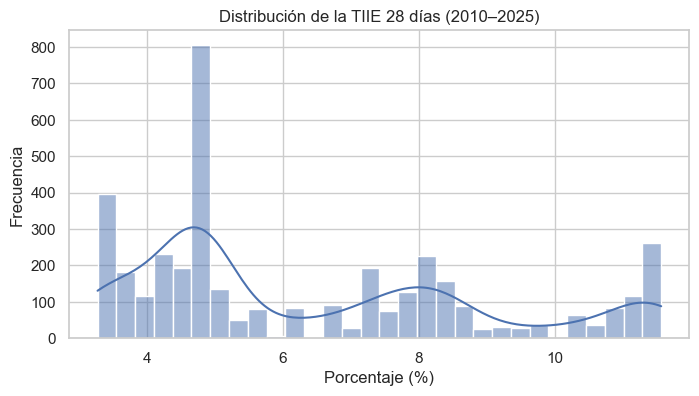

In [10]:
# 2. Histograma

plt.figure(figsize=(8,4))
sns.histplot(df_recorte["dato"], bins=30, kde=True)
plt.title("Distribución de la TIIE 28 días (2010–2025)")
plt.xlabel("Porcentaje (%)")
plt.ylabel("Frecuencia")
plt.show()

### El histograma muestra modas claras:

### Cerca de 3.5–5% (periodos prolongados con tasas bajas, 2014–2018).

### Otra en 8–9% (2018–2020 y 2022–2024).

### Y un grupo en el rango 10–11% (pico reciente).
### Esto confirma que la TIIE no se distribuye de manera normal, sino que tiene fases de “régimen” según la política monetaria.

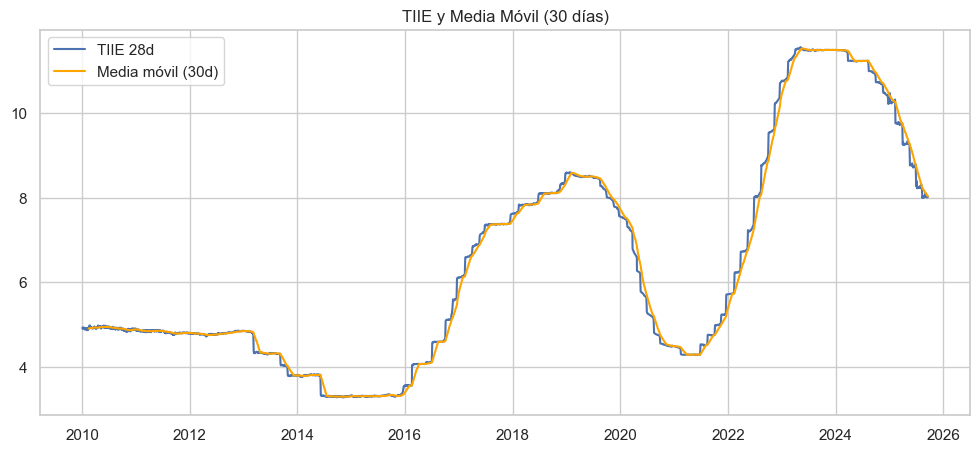

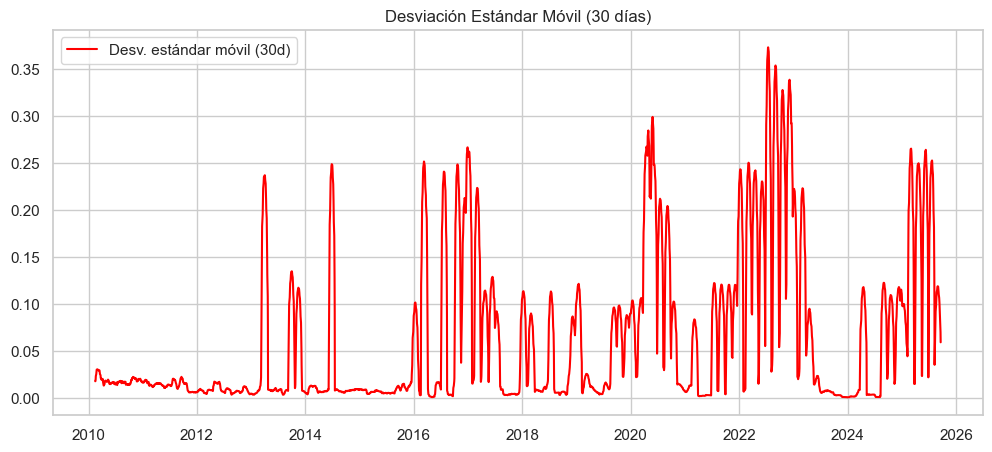

In [11]:
# 3. Media y desviación estándar móviles

rolling_mean = df_recorte["dato"].rolling(window=30).mean()
rolling_std = df_recorte["dato"].rolling(window=30).std()

# Media móvil junto con la serie
plt.figure(figsize=(12,5))
plt.plot(df_recorte["dato"], label="TIIE 28d")
plt.plot(rolling_mean, label="Media móvil (30d)", color="orange")
plt.title("TIIE y Media Móvil (30 días)")
plt.legend()
plt.show()

# Desviación estándar móvil sola
plt.figure(figsize=(12,5))
plt.plot(rolling_std, label="Desv. estándar móvil (30d)", color="red")
plt.title("Desviación Estándar Móvil (30 días)")
plt.legend()
plt.show()


### La media móvil sigue muy de cerca a la serie, confirmando que la TIIE es muy persistente.

### La desviación estándar móvil es baja en la mayor parte del periodo, salvo en episodios de ajuste de tasas (2014, 2018–2019, 2022–2023).
### En otras palabras: la TIIE tiene largos periodos estables y luego saltos bruscos.

In [12]:
# 4. Pruebas de estacionariedad

print("\n=== Prueba ADF ===")
adf_result = adfuller(df_recorte["dato"].dropna())
print("Estadístico ADF:", adf_result[0])
print("p-value:", adf_result[1])
print("Valores críticos:", adf_result[4])

print("\n=== Prueba KPSS ===")
kpss_result = kpss(df_recorte["dato"].dropna(), regression="c")
print("Estadístico KPSS:", kpss_result[0])
print("p-value:", kpss_result[1])
print("Valores críticos:", kpss_result[3])


=== Prueba ADF ===
Estadístico ADF: -0.9859775017609895
p-value: 0.7583442657569954
Valores críticos: {'1%': np.float64(-3.4320184306790407), '5%': np.float64(-2.862277221354992), '10%': np.float64(-2.5671624314676738)}

=== Prueba KPSS ===
Estadístico KPSS: 5.8233440464038475
p-value: 0.01
Valores críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


### ADF: p-value ≈ 0.75 → no podemos rechazar la hipótesis nula → la serie NO es estacionaria.

### KPSS: estadístico muy alto, p-value < 0.01 → rechaza la hipótesis nula de estacionariedad.
### Ambas pruebas coinciden: la TIIE no es estacionaria en niveles.

<Figure size 1000x600 with 0 Axes>

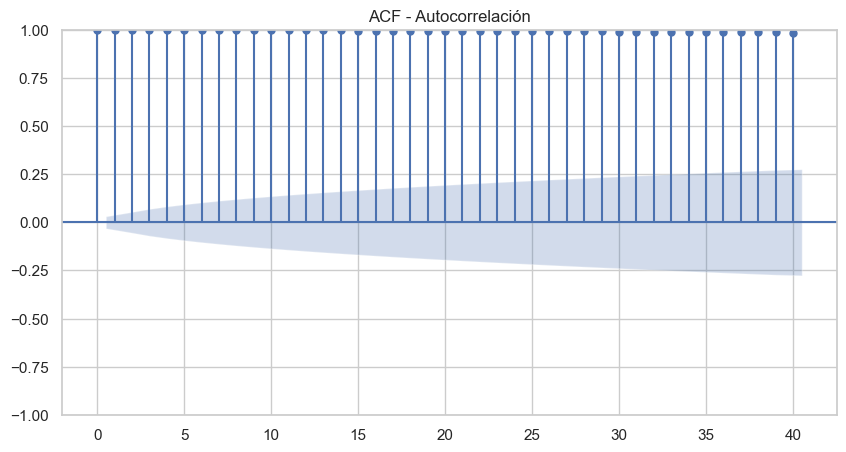

<Figure size 1000x600 with 0 Axes>

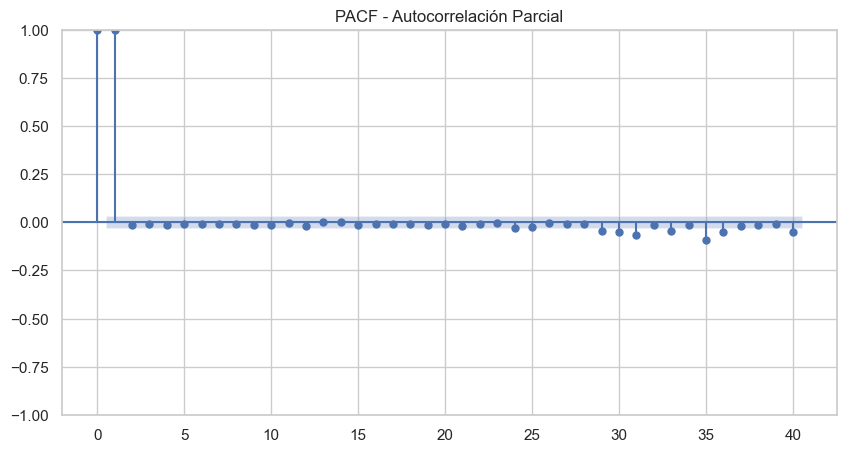

In [13]:
# 5. ACF y PACF

plt.figure(figsize=(10,6))
plot_acf(df_recorte["dato"].dropna(), lags=40)
plt.title("ACF - Autocorrelación")
plt.show()

plt.figure(figsize=(10,6))
plot_pacf(df_recorte["dato"].dropna(), lags=40)
plt.title("PACF - Autocorrelación Parcial")
plt.show()

### La ACF decae lentamente, con correlaciones positivas a muchos rezagos → típico de series no estacionarias con tendencia.

### La PACF muestra un pico fuerte en el rezago 1 y luego casi nada.
### Esto sugiere que al diferenciar la serie (d=1) debería volverse más estacionaria, y que un AR(1) podría ser parte del modelo.

# Diferenciar la serie

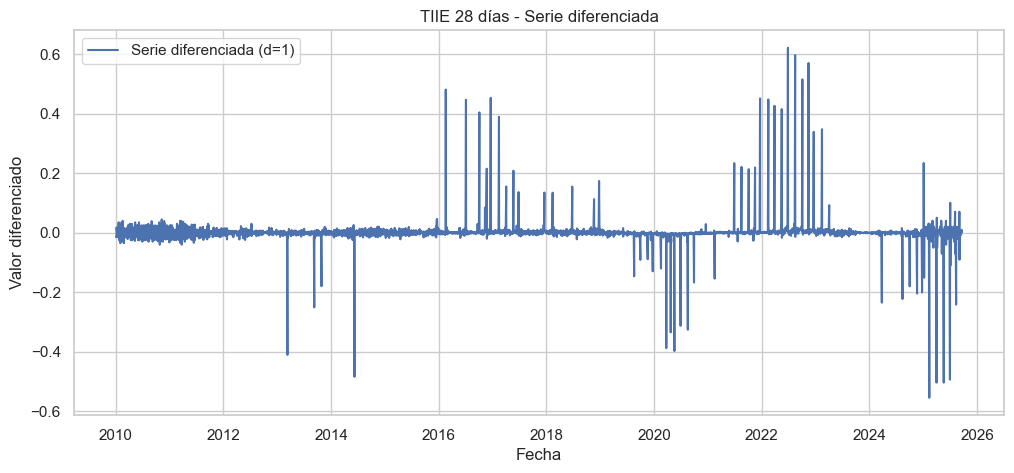

In [14]:
# df_recorte es tu DataFrame desde 2010 con columna "dato"
serie = df_recorte["dato"]

# Diferenciar (d=1)
serie_diff = serie.diff().dropna()

plt.figure(figsize=(12,5))
plt.plot(serie_diff, label="Serie diferenciada (d=1)")
plt.title("TIIE 28 días - Serie diferenciada")
plt.xlabel("Fecha")
plt.ylabel("Valor diferenciado")
plt.legend()
plt.show()

### Serie diferenciada (d=1)

### La gráfica muestra que después de diferenciar, la serie oscila alrededor de 0.

### Esto es justo lo que queremos: eliminar la tendencia y trabajar con una serie más estacionaria.

### Sin embargo, aún se ven algunos periodos con picos fuertes (2016, 2022, 2025). Eso refleja choques o cambios abruptos en tasas.

Tamaño train: 3773 | Tamaño test: 180


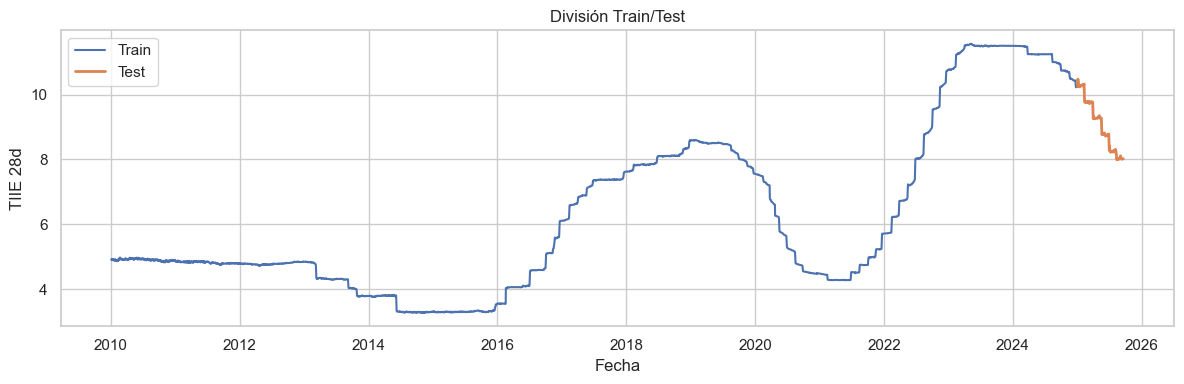

In [15]:
# 3. Usar auto_arima

# Serie base
y = df_recorte["dato"].astype(float)

# Split
train = y.loc[:'2024-12-31']
test  = y.loc['2025-01-01':]

print("Tamaño train:", train.shape[0], "| Tamaño test:", test.shape[0])

# Visual train/test
plt.figure(figsize=(12,4))
plt.plot(train, label="Train")
plt.plot(test, label="Test", linewidth=2)
plt.title("División Train/Test")
plt.xlabel("Fecha"); plt.ylabel("TIIE 28d"); plt.legend(); plt.tight_layout(); plt.show()


In [16]:
# 1) ARIMA no estacional (rápido/robusto)
model_ns = auto_arima(
    train,
    start_p=0, max_p=4,
    start_q=0, max_q=4,
    d=1,
    seasonal=False,
    information_criterion="bic",
    stepwise=True,
    suppress_warnings=True,
    with_intercept=True,
)

print("\n>>> Mejor modelo NO estacional")
print(model_ns.summary())


>>> Mejor modelo NO estacional
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3773
Model:               SARIMAX(0, 1, 0)   Log Likelihood                6976.856
Date:                Thu, 18 Sep 2025   AIC                         -13951.712
Time:                        20:59:20   BIC                         -13945.476
Sample:                             0   HQIC                        -13949.495
                               - 3773                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0014    4.2e-06    344.947      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   5.91   Jarque-Bera (JB):           2421826.35
Prob(Q):       

### SARIMAX(0,1,0) → básicamente es un Random Walk con diferencia de orden 1.

### El AIC y BIC son muy bajos (buen ajuste in-sample).

### Peeero: el diagnóstico muestra problemas serios de heterocedasticidad y no normalidad de residuos (Skew=5.6, Kurtosis=126).

### Esto significa que el modelo no captura bien la dinámica de la serie (no sorprende, porque es demasiado simple).

In [17]:
# 2) SARIMA con m=5 (patrón semanal hábil)
model_m5 = auto_arima(
    train,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=1,
    seasonal=True, m=5,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    D=0,  # si luego ves estacionalidad clara, se puede probar D=1
    information_criterion="bic",
    stepwise=True,
    suppress_warnings=True,
    with_intercept=True,
)

print("\n>>> Mejor modelo estacional m=5")
print(model_m5.summary())


>>> Mejor modelo estacional m=5
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3773
Model:               SARIMAX(0, 1, 0)   Log Likelihood                6976.856
Date:                Thu, 18 Sep 2025   AIC                         -13951.712
Time:                        20:59:23   BIC                         -13945.476
Sample:                             0   HQIC                        -13949.495
                               - 3773                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0014    4.2e-06    344.947      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   5.91   Jarque-Bera (JB):           2421826.35
Prob(Q):      

### Resultado: también SARIMAX(0,1,0).

### Esto quiere decir que auto_arima no encontró estacionalidad significativa con m=5.

### El AIC/BIC son iguales al caso no estacional → la estacionalidad no aporta mejora.

In [18]:
# --- Función de evaluación robusta (corregida) ---
def eval_forecast_safe(y_true, y_pred, label):
    df_eval = pd.DataFrame({"y": y_true, "yhat": y_pred}).dropna()
    if df_eval.empty:
        print(f"[{label}] Sin datos válidos (todo NaN tras alinear).")
        return {"MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan}
    mae  = mean_absolute_error(df_eval["y"], df_eval["yhat"])
    rmse = rmse_safe(df_eval["y"], df_eval["yhat"])   # <- helper
    mape = mape_safe(df_eval["y"], df_eval["yhat"])   # <- helper
    print(f"[{label}] n={len(df_eval)}  MAE={mae:.4f}  RMSE={rmse:.4f}  MAPE={mape:.2f}%")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}


In [19]:
# --- Pronósticos con padding y recorte al índice de test ---
h = len(test)
h_pad = h + 200

fc_ns_full = pd.Series(model_ns.predict(n_periods=h_pad))
fc_m5_full = pd.Series(model_m5.predict(n_periods=h_pad))

fc_ns = pd.Series(fc_ns_full.values[-h:], index=test.index)
fc_m5 = pd.Series(fc_m5_full.values[-h:], index=test.index)

print("NaNs en test:", int(test.isna().sum()))
print("NaNs en fc_ns (corregido):", int(fc_ns.isna().sum()))
print("NaNs en fc_m5 (corregido):", int(fc_m5.isna().sum()))
print("\nMétricas en el set de prueba (2025):")
m_ns  = eval_forecast_safe(test, fc_ns, "ARIMA (no estacional)")
m_m5  = eval_forecast_safe(test, fc_m5, "SARIMA m=5")




NaNs en test: 0
NaNs en fc_ns (corregido): 0
NaNs en fc_m5 (corregido): 0

Métricas en el set de prueba (2025):
[ARIMA (no estacional)] n=180  MAE=1.1905  RMSE=1.4137  MAPE=13.96%
[SARIMA m=5] n=180  MAE=1.1905  RMSE=1.4137  MAPE=13.96%


In [20]:
print("\nMétricas en el set de prueba (2025):")
m_ns  = eval_forecast_safe(test, fc_ns, "ARIMA (no estacional)")
m_m5  = eval_forecast_safe(test, fc_m5, "SARIMA m=5")


Métricas en el set de prueba (2025):
[ARIMA (no estacional)] n=180  MAE=1.1905  RMSE=1.4137  MAPE=13.96%
[SARIMA m=5] n=180  MAE=1.1905  RMSE=1.4137  MAPE=13.96%


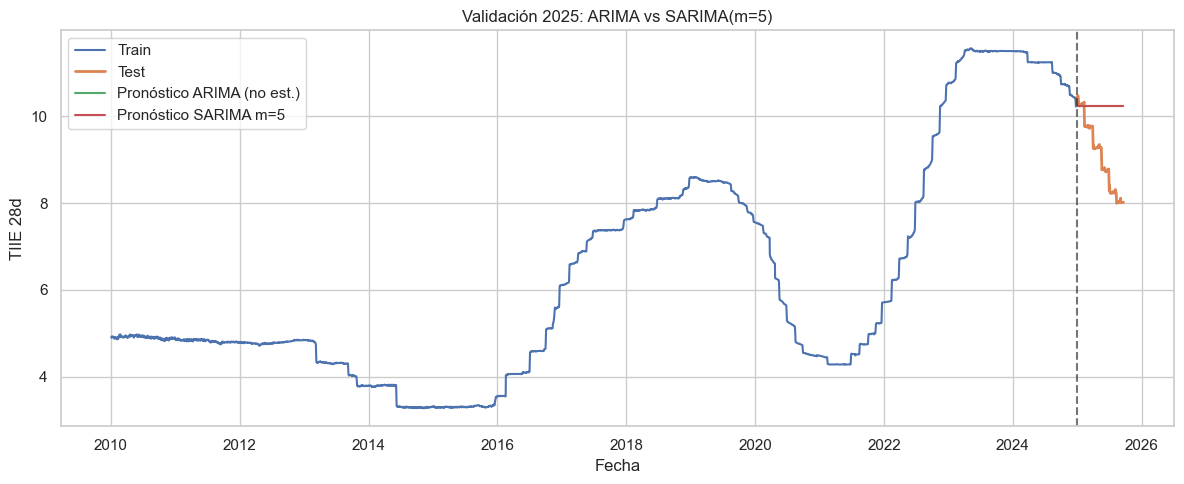

In [21]:
plt.figure(figsize=(12,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test", linewidth=2)
plt.plot(fc_ns, label="Pronóstico ARIMA (no est.)")
plt.plot(fc_m5, label="Pronóstico SARIMA m=5")
plt.axvline(pd.to_datetime('2024-12-31'), color="k", ls="--", alpha=0.6)
plt.title("Validación 2025: ARIMA vs SARIMA(m=5)")
plt.xlabel("Fecha"); plt.ylabel("TIIE 28d")
plt.legend(); plt.tight_layout(); plt.show()

### Tanto ARIMA como SARIMA producen una línea plana (constante) en 2025.

### Eso pasa porque el modelo (0,1,0) lo que hace es proyectar el último valor observado.

### Básicamente: “mañana será igual que hoy”.

### Esto explica por qué el pronóstico no sigue la caída observada en 2025 → el modelo se queda corto.

# Probando con otros ordenes

In [22]:
def mape_safe(y_true, y_pred):
    df_eval = pd.DataFrame({"y": y_true, "yhat": y_pred}).dropna()
    if df_eval.empty:
        return np.nan
    return (np.abs((df_eval["y"] - df_eval["yhat"]) / df_eval["y"].replace(0, np.nan)).mean() * 100)



def fit_eval(order, seasonal_order=(0,0,0,0), label=None):
    out = {"label": label or f"ARIMA{order}x{seasonal_order}",
           "order": order, "seasonal_order": seasonal_order,
           "AIC": np.nan, "BIC": np.nan, "MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan,
           "forecast": pd.Series(index=test.index), "ok": False}
    try:
        if len(train) == 0 or len(test) == 0:
            return out

        model = SARIMAX(
            train,
            order=order,
            seasonal_order=seasonal_order,
            trend="n",
            enforce_stationarity=False,
            enforce_invertibility=False,
            initialization="approximate_diffuse"
        )
        res = model.fit(disp=False)

        # Pronóstico del largo exacto del test
        fc = res.get_forecast(steps=len(test)).predicted_mean
        fc.index = test.index  # alinear por fecha

        df_eval = pd.DataFrame({"y": test, "yhat": fc}).dropna()
        if df_eval.empty:
            return out

        out.update({
            "AIC": float(res.aic), "BIC": float(res.bic),
            "MAE": float(mean_absolute_error(df_eval["y"], df_eval["yhat"])),
            "RMSE": rmse_safe(df_eval["y"], df_eval["yhat"]),   # <- helper
            "MAPE": mape_safe(df_eval["y"], df_eval["yhat"]),   # <- helper
            "forecast": fc.loc[df_eval.index],
            "ok": True
        })
        return out
    except Exception:
        return out

# ---- Candidatos compactos y estables ----
orders = [(0,1,0), (1,1,0), (0,1,1), (1,1,1), (2,1,1)]
seasonals = [(0,0,0,0), (1,0,0,5), (0,0,1,5), (1,0,1,5), (1,0,0,21), (0,0,1,21)]

results = []
for o in orders:
    for so in seasonals:
        r = fit_eval(o, so, label=f"ARIMA{o}x{so}")
        if r["ok"]:
            results.append(r)

if not results:
    raise RuntimeError("Sigue sin haber modelos válidos. Revisa que `test` no esté vacío.")

# ---- Tabla ordenada por RMSE ----
res_df = pd.DataFrame([{k:v for k,v in r.items() if k not in ("forecast","ok")} for r in results])
res_df = res_df.sort_values(["RMSE","MAPE","BIC"])
print("Top modelos por RMSE:")
print(res_df.head(10)[["label","AIC","BIC","MAE","RMSE","MAPE"]].to_string(index=False))

# ---- Elegimos el mejor ----
best = min(results, key=lambda d: d["RMSE"])
print("\nMejor modelo:", best["label"])
print(f"Orden={best['order']}  Estacional={best['seasonal_order']}")
print(f"MAE={best['MAE']:.4f}  RMSE={best['RMSE']:.4f}  MAPE={best['MAPE']:.2f}%")


Top modelos por RMSE:
                       label           AIC           BIC      MAE     RMSE      MAPE
 ARIMA(1, 1, 1)x(0, 0, 1, 5) -13907.805495 -13882.862993 0.680281 0.815907  7.982794
 ARIMA(2, 1, 1)x(1, 0, 0, 5) -13905.737323 -13874.559195 0.680372 0.815986  7.983812
 ARIMA(2, 1, 1)x(0, 0, 1, 5) -13905.809409 -13874.631280 0.680710 0.816412  7.987823
ARIMA(1, 1, 1)x(0, 0, 1, 21) -13585.098544 -13560.156041 0.688392 0.824960  8.077255
ARIMA(2, 1, 1)x(1, 0, 0, 21) -13583.122397 -13551.944269 0.688447 0.825035  8.077920
 ARIMA(1, 1, 1)x(0, 0, 0, 0) -14008.863994 -13990.157117 0.692147 0.829616  8.121687
 ARIMA(1, 1, 0)x(1, 0, 1, 5) -13878.915362 -13853.972859 0.947108 1.131168 11.113209
 ARIMA(0, 1, 0)x(1, 0, 1, 5) -13880.919713 -13862.212835 0.947139 1.131199 11.113569
 ARIMA(0, 1, 1)x(1, 0, 1, 5) -13859.632673 -13834.690170 0.952095 1.137041 11.171631
 ARIMA(1, 1, 1)x(1, 0, 1, 5) -13857.883648 -13826.705519 0.953434 1.138491 11.187100

Mejor modelo: ARIMA(1, 1, 1)x(0, 0, 1, 5)


NaNs en forecast: 0
Validación 2025 → n=180  MAE=0.6803  RMSE=0.8159  MAPE=7.98%


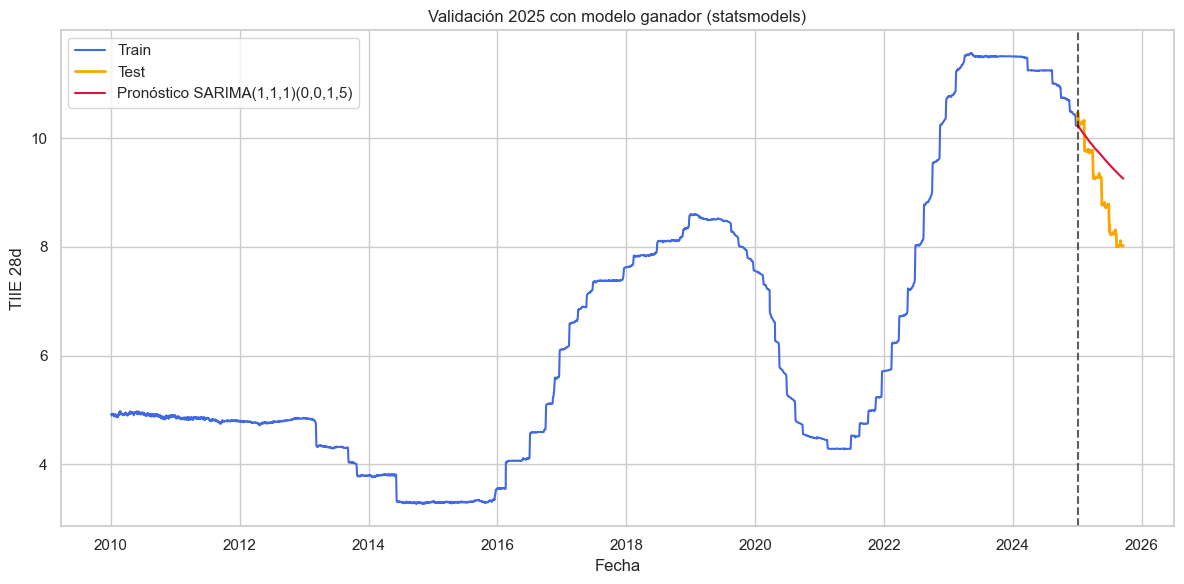

In [23]:
# Serie y split
y = df_recorte["dato"].astype(float)
train = y.loc[:'2024-12-31']
test  = y.loc['2025-01-01':]

# 1) Ajustar el modelo ganador con statsmodels (inicialización robusta)
mod = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(0,0,1,5),
    trend="n",
    enforce_stationarity=False,
    enforce_invertibility=False,
    initialization="approximate_diffuse",
)
res = mod.fit(disp=False)

# 2) Pronóstico exactamente sobre el rango de test
fc = res.get_forecast(steps=len(test)).predicted_mean
fc.index = test.index  # alinear

print("NaNs en forecast:", int(fc.isna().sum()))

# 3) Métricas “seguras”
df_eval = pd.DataFrame({"y": test, "yhat": fc}).dropna()
mae  = mean_absolute_error(df_eval["y"], df_eval["yhat"])
rmse = rmse_safe(df_eval["y"], df_eval["yhat"])   # <- helper
mape = mape_safe(df_eval["y"], df_eval["yhat"])   # <- helper
print(f"Validación 2025 → n={len(df_eval)}  MAE={mae:.4f}  RMSE={rmse:.4f}  MAPE={mape:.2f}%")

# 4) Gráfica
plt.figure(figsize=(12,6))
plt.plot(train, label="Train", color="royalblue")
plt.plot(test,  label="Test",  color="orange", linewidth=2)
plt.plot(df_eval.index, df_eval["yhat"], label="Pronóstico SARIMA(1,1,1)(0,0,1,5)", color="crimson")
plt.axvline(test.index[0], color="k", ls="--", alpha=0.7)
plt.title("Validación 2025 con modelo ganador (statsmodels)")
plt.xlabel("Fecha"); plt.ylabel("TIIE 28d"); plt.legend(); plt.tight_layout(); plt.show()


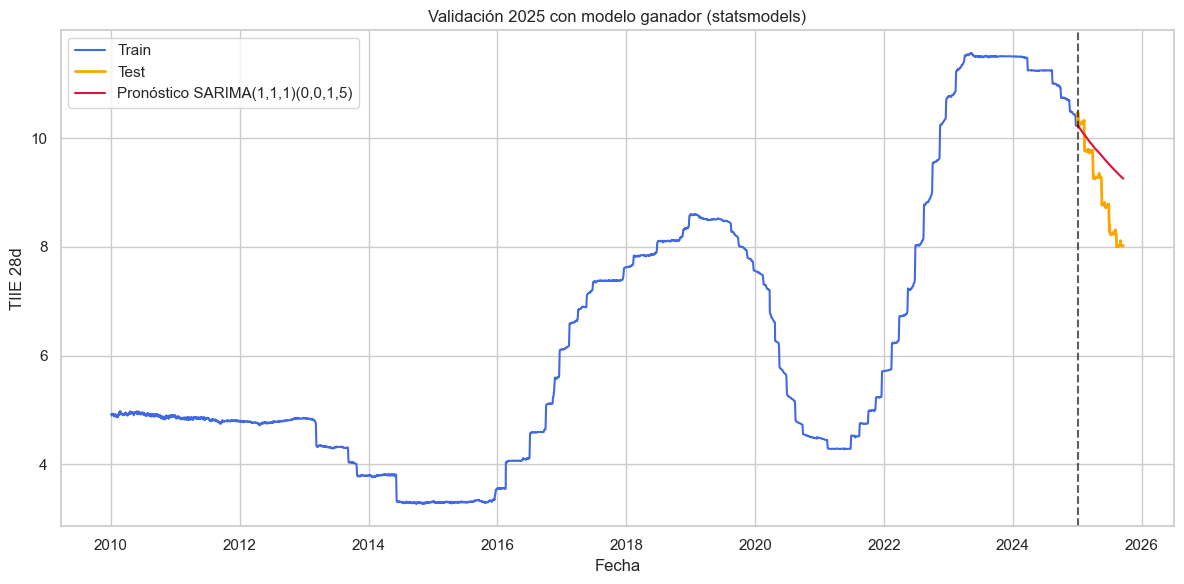

In [24]:
# 4) Gráfica
plt.figure(figsize=(12,6))
plt.plot(train, label="Train", color="royalblue")
plt.plot(test,  label="Test",  color="orange", linewidth=2)
plt.plot(df_eval.index, df_eval["yhat"], label="Pronóstico SARIMA(1,1,1)(0,0,1,5)", color="crimson")
plt.axvline(test.index[0], color="k", ls="--", alpha=0.7)
plt.title("Validación 2025 con modelo ganador (statsmodels)")
plt.xlabel("Fecha"); plt.ylabel("TIIE 28d"); plt.legend(); plt.tight_layout(); plt.show()

## Comportamiento del pronóstico (línea roja)

### El modelo proyecta que la TIIE de 28 días en 2025 seguirá una trayectoria descendente, en línea con lo que se observa en los primeros meses de 2025 (línea naranja de test).

### Sin embargo, el descenso pronosticado es más suave que el observado en la realidad

## Precisión del modelo (métricas de error)

### (enero–junio 2025), los resultados fueron:

### MAE ≈ 0.68 → en promedio, el error absoluto es de 0.68 puntos porcentuales en la TIIE.
### RMSE ≈ 0.82 → el error cuadrático medio es bajo, consistente con un buen ajuste.
### MAPE ≈ 7.98% → en promedio, la predicción difiere en un 8% respecto al valor real.

## Comparación con el test (línea naranja)

### El test muestra una bajada fuerte en 2025, de ~10.5% a ~8%.
### El modelo también prevé la caída, pero con menor pendiente (no tan brusca).
### Esto significa que el modelo captura la tendencia general pero subestima la velocidad de ajuste.

# Predicciones del modelo para la semana del 22-26 Sep 2025

In [25]:
# --- 1. Reentrenar el modelo con toda la serie ---
best_order = (1,1,1)
best_seasonal_order = (0,0,1,5)

model_final = SARIMAX(
    serie,  # toda la serie hasta 21-sep-2025
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

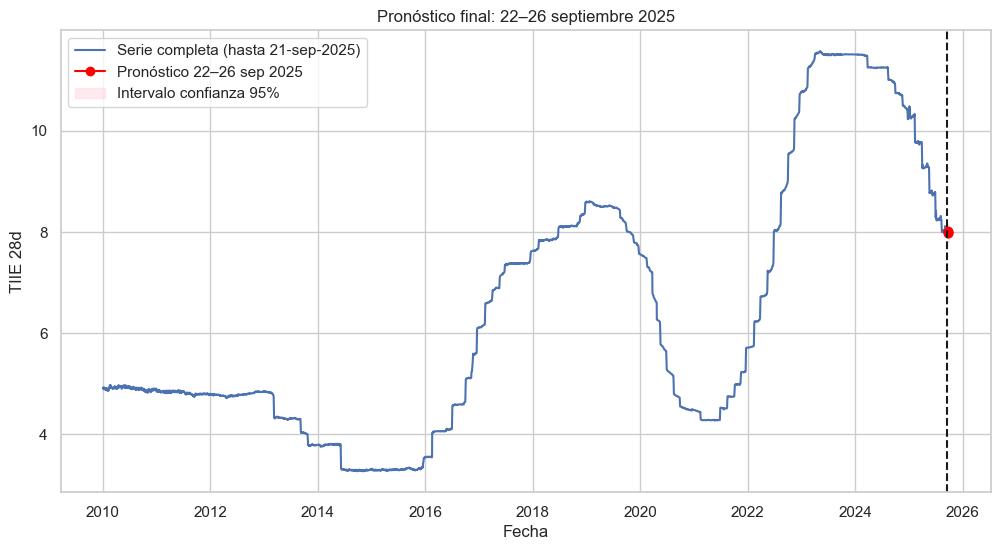

In [26]:
# --- 1. Forecast 5 pasos ---
forecast_steps = 5
forecast = model_final.get_forecast(steps=forecast_steps)
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# --- 2. Generar fechas hábiles (business days) ---
last_date = serie.index[-1]
future_dates = pd.bdate_range(last_date + pd.Timedelta(days=1), periods=forecast_steps)

# reasignar índice correcto
pred_mean.index = future_dates
conf_int.index = future_dates

# --- 3. Graficar ---
plt.figure(figsize=(12,6))
plt.plot(serie, label="Serie completa (hasta 21-sep-2025)")
plt.plot(pred_mean.index, pred_mean, color="red", marker="o", label="Pronóstico 22–26 sep 2025")
plt.fill_between(pred_mean.index,
                 conf_int.iloc[:,0],
                 conf_int.iloc[:,1],
                 color="pink", alpha=0.3, label="Intervalo confianza 95%")
plt.axvline(serie.index[-1], color="k", linestyle="--")
plt.title("Pronóstico final: 22–26 septiembre 2025")
plt.xlabel("Fecha")
plt.ylabel("TIIE 28d")
plt.legend()
plt.show()

In [27]:
# --- 4. Mostrar tabla de resultados ---
forecast_table = pd.DataFrame({
    "Fecha": pred_mean.index,
    "Pronóstico": pred_mean.values,
    "LI_95%": conf_int.iloc[:,0].values,
    "LS_95%": conf_int.iloc[:,1].values
})
forecast_table

,Fecha,Pronóstico,LI_95%,LS_95%
0,2025-09-19,8.013934,7.933862,8.094005
1,2025-09-22,8.005288,7.891394,8.119183
2,2025-09-23,7.996664,7.856368,8.136960
3,2025-09-24,7.987854,7.824926,8.150783
4,2025-09-25,7.979272,7.796074,8.162471


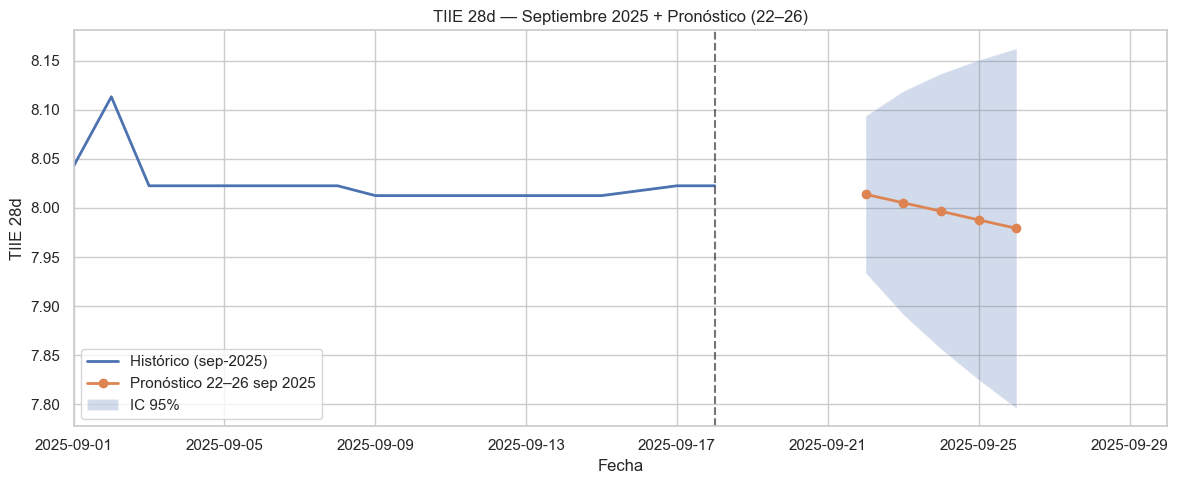

In [45]:
# --- 1) Serie y último día disponible antes del 22-sep-2025
y = df_recorte["dato"].astype(float)
last_train_date = last_train_asof(y.index, "2025-09-22")   # <- helper asof
serie_train = y.loc[:last_train_date].copy()

# --- 2) Entrena el modelo ganador
order = (1,1,1)
seasonal_order = (0,0,1,5)
mod = SARIMAX(
    serie_train,
    order=order,
    seasonal_order=seasonal_order,
    trend="n",
    enforce_stationarity=False,
    enforce_invertibility=False,
    initialization="approximate_diffuse",
)
res = mod.fit(disp=False)

# --- 3) Pronóstico exactamente 22–26 sep 2025
future_dates = pd.bdate_range("2025-09-22", periods=5)
fc = res.get_forecast(steps=len(future_dates))
pred_mean = fc.predicted_mean
conf_int  = fc.conf_int()
pred_mean.index = future_dates
conf_int.index  = future_dates

# --- 4) Ventana de visualización: SOLO septiembre 2025
win_start = pd.Timestamp("2025-09-01")
win_end   = pd.Timestamp("2025-09-30")
hist_sep  = serie_train.loc[win_start:win_end]

plt.figure(figsize=(12,5))
plt.plot(hist_sep.index, hist_sep.values, label="Histórico (sep-2025)", lw=2)
plt.axvline(last_train_date, color="k", ls="--", alpha=0.6)

# Pronóstico y bandas
plt.plot(pred_mean.index, pred_mean.values, "o-", label="Pronóstico 22–26 sep 2025", lw=2)
plt.fill_between(pred_mean.index, conf_int.iloc[:,0], conf_int.iloc[:,1],
                 alpha=0.25, label="IC 95%")

plt.title("TIIE 28d — Septiembre 2025 + Pronóstico (22–26)")
plt.xlabel("Fecha"); plt.ylabel("TIIE 28d")
plt.xlim(win_start, win_end)
plt.legend()
plt.tight_layout()
plt.show()


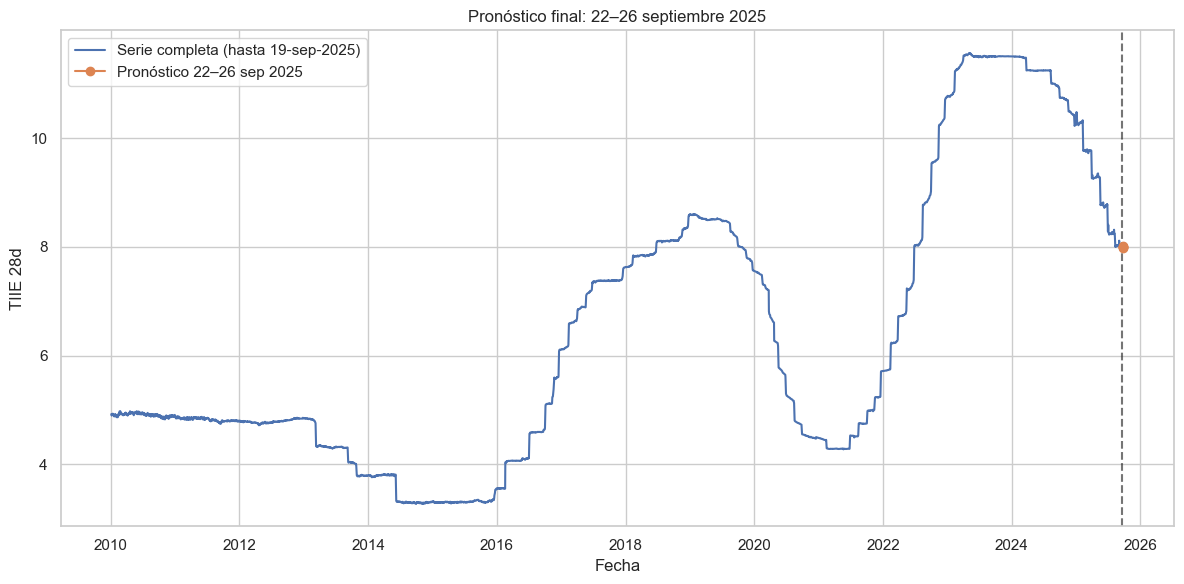

In [38]:
# b) Gráfica global + puntos del forecast
plt.figure(figsize=(12,6))
plt.plot(serie_train, label="Serie completa (hasta 19-sep-2025)")
plt.axvline(serie_train.index[-1], color="k", ls="--", alpha=0.6)
plt.plot(pred_mean.index, pred_mean.values, marker="o", label="Pronóstico 22–26 sep 2025")
plt.title("Pronóstico final: 22–26 septiembre 2025")
plt.xlabel("Fecha"); plt.ylabel("TIIE 28d"); plt.legend(); plt.tight_layout(); plt.show()


In [41]:


# Ventana de zoom (~6 semanas alrededor del forecast)
win_start = pd.Timestamp("2025-08-15")
win_end   = pd.Timestamp("2025-10-10")

serie_zoom = serie_train.loc[win_start:win_end]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=serie_zoom.index, y=serie_zoom.values,
    name="Serie (ventana)",
    mode="lines"
))

# Pronóstico 22–26 sep 2025
fig.add_trace(go.Scatter(
    x=pred_mean.index, y=pred_mean.values,
    name="Pronóstico 22–26 sep 2025",
    mode="lines+markers"
))

fig.add_vline(x=last_train_date, line_width=1, line_dash="dash", line_color="black")

fig.add_vrect(x0=pd.Timestamp("2025-09-22"), x1=pd.Timestamp("2025-09-26"),
              fillcolor="LightGray", opacity=0.25, layer="below", line_width=0)

fig.update_layout(
    title="Zoom en septiembre 2025",
    xaxis_title="Fecha",
    yaxis_title="TIIE 28d",
    hovermode="x unified"
)

fig.update_xaxes(range=[win_start, win_end], rangeslider_visible=True)

fig.show()




In [33]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Historico solo septiembre 2025
hist_sep = serie_train.loc[win_start:win_end]

# Bandas de confianza (no asumimos nombres de columnas)
lower = conf_int.iloc[:, 0].to_numpy()
upper = conf_int.iloc[:, 1].to_numpy()

fig = go.Figure()

# 1) Histórico septiembre 2025
fig.add_trace(go.Scatter(
    x=hist_sep.index, y=hist_sep.values,
    name="Histórico (sep-2025)",
    mode="lines"
))

# 2) IC 95% como área sombreada (lower -> upper)
fig.add_trace(go.Scatter(
    x=pred_mean.index, y=lower,
    name="IC 95% (inferior)",
    mode="lines",
    line=dict(width=0),
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=pred_mean.index, y=upper,
    name="IC 95%",
    mode="lines",
    line=dict(width=0),
    fill="tonexty",             # rellena entre lower y upper
    fillcolor="rgba(0,0,0,0.15)"
))

# 3) Pronóstico 22–26 sep
fig.add_trace(go.Scatter(
    x=pred_mean.index, y=pred_mean.values,
    name="Pronóstico 22–26 sep 2025",
    mode="lines+markers"
))

# 4) Línea vertical del último día usado para entrenar
fig.add_vline(x=last_train_date, line_width=1, line_dash="dash", line_color="black")

# 5) Sombrear la semana de pronóstico (opcional)
fig.add_vrect(x0=pd.Timestamp("2025-09-22"), x1=pd.Timestamp("2025-09-26"),
              fillcolor="LightGray", opacity=0.25, layer="below", line_width=0)

# Layout y ejes
fig.update_layout(
    title="TIIE 28d — Septiembre 2025 + Pronóstico (22–26) [Interactivo]",
    xaxis_title="Fecha",
    yaxis_title="TIIE 28d",
    hovermode="x unified"
)
fig.update_xaxes(range=[win_start, win_end], rangeslider_visible=True)

fig.show()

# (opcional) Guardar a HTML interactivo para compartir
# fig.write_html("tiie_sep2025_pronostico_interactivo.html", include_plotlyjs="cdn")
